Setup

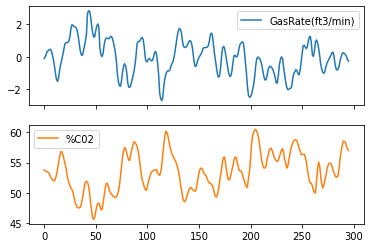

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import warnings

data = pandas.read_csv('../Datasets/Gas_Furnace_Data.csv')
data.plot(subplots=True)
plt.show()

Time Series Analysis

In [5]:
def adf_test(data):
  for col in data.columns:
    results = adfuller(data[col])
    print("-----------------")
    print(col)
    print("ADF Value:", results[0])
    print("P-Value:", results[1])
    print("Critical Values:")
    for key in results[4].keys():
      print(key, results[4][key])

#adf_test(data)
data_dif = data.diff().dropna()
#adf_test(data_dif)

Data Preparation

In [6]:
values = data_dif.values
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

# Receives a time series dataset and creates training, test and, optionally, validation sets
# data: dataset
# order: number of previous timesteps to be included in the input (0 or higher)
# split: index that separates training and test sets
# val_split: size of validation set (0 or higher)
# step: offset between x and y values (1 or higher)
def series_to_supervised(data, order, split, val_split=0, step=1):
  df = pandas.DataFrame(data)
  for col in df.columns:
    df = df.rename(columns = {col: 'var' + str(col)})
  df_shift = df.shift(-step).dropna()

  if val_split == 0:
    val_x_split = -len(df)
    val_y_split = -len(df_shift)
    warnings.warn("x_val and y_val are empty DataFrames.")
  else:
    val_x_split = val_split
    val_y_split = val_split

  y_train = df_shift[df_shift.columns][:split]
  y_test = df_shift[df_shift.columns][split:-val_y_split]
  y_val = df_shift[df_shift.columns][-val_y_split:]

  shifts = {}

  if order > 0:
    for i in range(1, order + 1):
      shifts['-' + str(i)] = df.shift(i)
  for key in shifts.keys():
    for col in shifts[key].columns:
      df[str(col) + key] = shifts[key][col]

  df = df.drop(df.index[-step:])
  x_train = df[df.columns][:split]
  x_test = df[df.columns][split:-val_x_split]
  x_val = df[df.columns][-val_x_split:]

  x_train = x_train.fillna(0)
  x_test = x_test.fillna(0)

  return x_train, x_test, y_train, y_test, x_val, y_val

data_dif = data.diff().dropna()
x_train, x_test, y_train, y_test, x_val, y_val = series_to_supervised(scaled, 1, 100)
x_train = np.reshape(x_train.values, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test.values, (x_test.shape[0], x_test.shape[1], 1))
y_train = y_train.values[:, 0]
y_test = y_test.values[:, 0]

<ipython-input-6-094c61c5dc96>:20: UserWarning: x_val and y_val are empty DataFrames.
  warnings.warn("x_val and y_val are empty DataFrames.")


Model Setup

In [7]:
lstm_model = keras.models.Sequential([
    #layers.LSTM(10, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True),
    layers.Bidirectional(layers.LSTM(20, return_sequences=True, bias_regularizer=regularizers.L1L2(l1=0.1, l2=0.0)), input_shape=(x_train.shape[1], x_train.shape[2])),
    #layers.Dropout(0.2),
    #layers.Dense(1)
    layers.TimeDistributed(layers.Dense(1))
])
lstm_model.compile(loss='mae', optimizer='adam')
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 4, 40)             3520      
_________________________________________________________________
time_distributed (TimeDistri (None, 4, 1)              41        
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = lstm_model.fit(x_train, y_train, epochs=100, batch_size=1, validation_data=(x_test, y_test), shuffle=False)

Epoch 1/100
100/100 [==============================] - 8s 28ms/step - loss: 4.0960 - val_loss: 3.7672
Epoch 2/100
100/100 [==============================] - 1s 11ms/step - loss: 3.6668 - val_loss: 3.3637
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 3.2576 - val_loss: 2.9633
Epoch 4/100
100/100 [==============================] - 1s 11ms/step - loss: 2.8528 - val_loss: 2.5612
Epoch 5/100
100/100 [==============================] - 1s 14ms/step - loss: 2.4511 - val_loss: 2.1609
Epoch 6/100
100/100 [==============================] - 1s 13ms/step - loss: 2.0496 - val_loss: 1.7613
Epoch 7/100
100/100 [==============================] - 1s 12ms/step - loss: 1.6492 - val_loss: 1.3608
Epoch 8/100
100/100 [==============================] - 1s 11ms/step - loss: 1.2487 - val_loss: 0.9611
Epoch 9/100
100/100 [==============================] - 1s 11ms/step - loss: 0.8487 - val_loss: 0.5604
Epoch 10/100
100/100 [==============================] - 1s 11ms/step - loss: 0.448

100/100 [==============================] - 2s 19ms/step - loss: 0.1276 - val_loss: 0.1560
Epoch 81/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1270 - val_loss: 0.1564
Epoch 82/100
100/100 [==============================] - 2s 16ms/step - loss: 0.1275 - val_loss: 0.1554
Epoch 83/100
100/100 [==============================] - 2s 18ms/step - loss: 0.1274 - val_loss: 0.1558
Epoch 84/100
100/100 [==============================] - 1s 14ms/step - loss: 0.1274 - val_loss: 0.1558
Epoch 85/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1266 - val_loss: 0.1563
Epoch 86/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1266 - val_loss: 0.1563
Epoch 87/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1268 - val_loss: 0.1558
Epoch 88/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1266 - val_loss: 0.1567
Epoch 89/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1264 - 

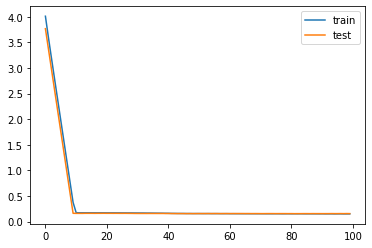

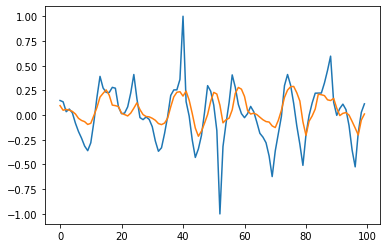

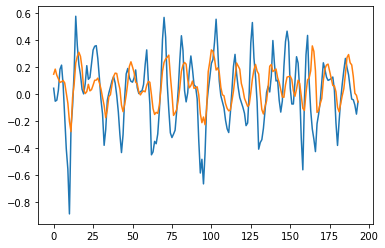

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
pr = lstm_model.predict(x_train)
plt.plot(np.arange(len(y_train)), y_train)
plt.plot(np.arange(len(y_train)), pr[:, 0, 0])
plt.show()
pr = lstm_model.predict(x_test)
plt.plot(np.arange(len(y_test)), y_test)
plt.plot(np.arange(len(y_test)), pr[:, 0, 0])
plt.show()

Model prediction using Monte Carlo Dropout

In [10]:
seed = np.random.randint(2 ** 16)
seed = 2 ** 16

In [11]:
def get_dropout_model():
  inputs = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
  x = layers.Bidirectional(layers.LSTM(20, return_sequences=False, bias_regularizer=regularizers.L1L2(l1=0.1, l2=0.0)))(inputs)
  x = layers.Dropout(0.2)(x, training=True)
  outputs = layers.Dense(1)(x)
  model = keras.models.Model(inputs, outputs)
  return model

In [12]:
dropout_model = get_dropout_model()

dropout_model.compile(loss='mae', optimizer='adam')
dropout_model.summary()

history = dropout_model.fit(x_train, y_train, epochs=100, batch_size=1, validation_data=(x_test, y_test), shuffle=False)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4, 1)]            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40)                3520      
_________________________________________________________________
dropout (Dropout)            (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 41        
Total params: 3,561
Trainable params: 3,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
100/100 [==============================] - 7s 25ms/step - loss: 4.1024 - val_loss: 3.7709
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 3.6691 - val_loss: 3.3607
Epoch 3/100
100/100 [==============================] 

Epoch 72/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1012 - val_loss: 0.1149
Epoch 73/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1024 - val_loss: 0.1023
Epoch 74/100
100/100 [==============================] - 1s 10ms/step - loss: 0.0974 - val_loss: 0.1131
Epoch 75/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1028 - val_loss: 0.1024
Epoch 76/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1004 - val_loss: 0.1023
Epoch 77/100
100/100 [==============================] - 1s 11ms/step - loss: 0.1049 - val_loss: 0.1050
Epoch 78/100
100/100 [==============================] - 1s 13ms/step - loss: 0.0967 - val_loss: 0.1052
Epoch 79/100
100/100 [==============================] - 1s 11ms/step - loss: 0.0991 - val_loss: 0.1102
Epoch 80/100
100/100 [==============================] - 1s 10ms/step - loss: 0.1045 - val_loss: 0.1043
Epoch 81/100
100/100 [==============================] - 1s 10ms/step - lo

In [13]:
predictions = []
t = 20
for i in range(len(x_test)):
  current_pred = []
  inp = np.reshape(x_test[i], (1, x_test[i].shape[0], x_test[i].shape[1]))
  for j in range(t):
    current_pred.append(dropout_model.predict(inp)[0, 0])
  predictions.append(current_pred)

In [14]:
predictions_df = pandas.DataFrame()
pred_array = np.array(predictions)
predictions_df['mean'] = pred_array.mean(axis=1).reshape(-1,)
predictions_df['std'] = pred_array.std(axis=1).reshape(-1,)

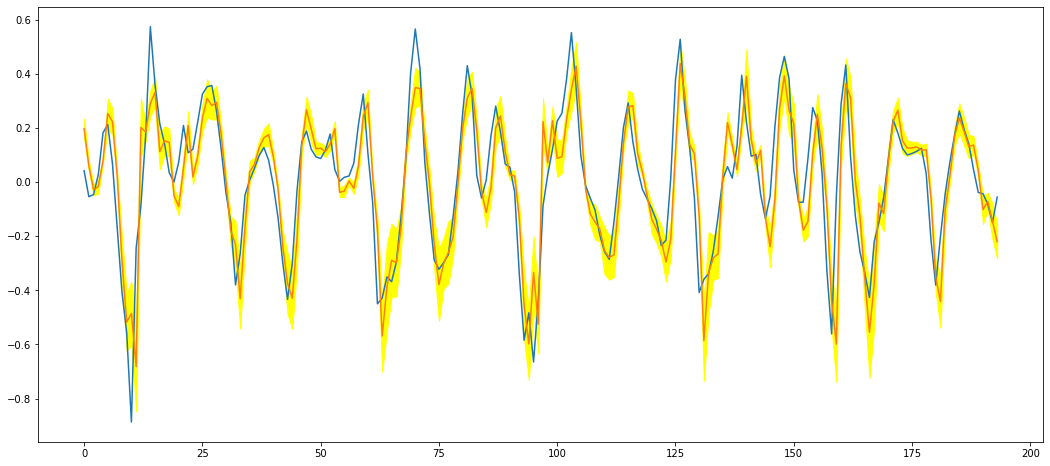

In [15]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(y_test)
ax.plot(predictions_df['mean'].values)
ax.fill_between(np.arange(len(y_test)), predictions_df['mean'].values - 2 * predictions_df['std'], predictions_df['mean'].values + 2 * predictions_df['std'], color='yellow')

#predictions_df.plot(yerr='std')